<a href="https://colab.research.google.com/github/abyaannn/UAS_DeepLearning_TrafficLight_Detection/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!pip install torchinfo

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abyandaffiapriansyah","key":"085f0dd0a855062da70da6b5ea00b536"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d wjybuqi/traffic-light-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/wjybuqi/traffic-light-detection-dataset
License(s): CC0-1.0
100% 873M/873M [00:07<00:00, 90.6MB/s]
100% 873M/873M [00:07<00:00, 126MB/s] 


In [6]:
!unzip -o traffic-light-detection-dataset.zip

Archive:  traffic-light-detection-dataset.zip
  inflating: submit_example.json     
  inflating: test_dataset/test_images/00007.jpg  
  inflating: test_dataset/test_images/00009.jpg  
  inflating: test_dataset/test_images/00024.jpg  
  inflating: test_dataset/test_images/00035.jpg  
  inflating: test_dataset/test_images/00038.jpg  
  inflating: test_dataset/test_images/00044.jpg  
  inflating: test_dataset/test_images/00051.jpg  
  inflating: test_dataset/test_images/00060.jpg  
  inflating: test_dataset/test_images/00069.jpg  
  inflating: test_dataset/test_images/00071.jpg  
  inflating: test_dataset/test_images/00074.jpg  
  inflating: test_dataset/test_images/00075.jpg  
  inflating: test_dataset/test_images/00086.jpg  
  inflating: test_dataset/test_images/00089.jpg  
  inflating: test_dataset/test_images/00092.jpg  
  inflating: test_dataset/test_images/00097.jpg  
  inflating: test_dataset/test_images/00105.jpg  
  inflating: test_dataset/test_images/00112.jpg  
  inflating: tes

In [7]:
!ls -F

!ls -F traffic-light-detection-dataset

kaggle.json   submit_example.json  traffic-light-detection-dataset.zip
sample_data/  test_dataset/	   train_dataset/
ls: cannot access 'traffic-light-detection-dataset': No such file or directory


In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import time
import pandas as pd
import numpy as np
import json
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

DIR_INPUT = ''
DIR_IMAGES = "train_dataset/train_images/"
DIR_IMAGES_TEST = "test_dataset/test_images/"

In [9]:
with open("train_dataset/train.json") as f:
    data_dict = json.load(f)

# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)

In [10]:
data_tf = pd.read_csv('traffic_lights.csv')

In [11]:
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)

In [12]:
df = pd.read_csv('traffic_lights_labels.csv')

In [13]:
df.head()


filename    xmin    ymin    xmax    ymax  color
0  00001.jpg  1026.5   741.8  1077.5   910.9    red
1  00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2  00003.jpg  2574.3   868.7  2632.3   887.1    red
3  00003.jpg  2252.1   899.6  2300.8   918.7  green
4  00004.jpg   833.3  1163.2   843.6  1184.8  green

In [14]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [15]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


In [16]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

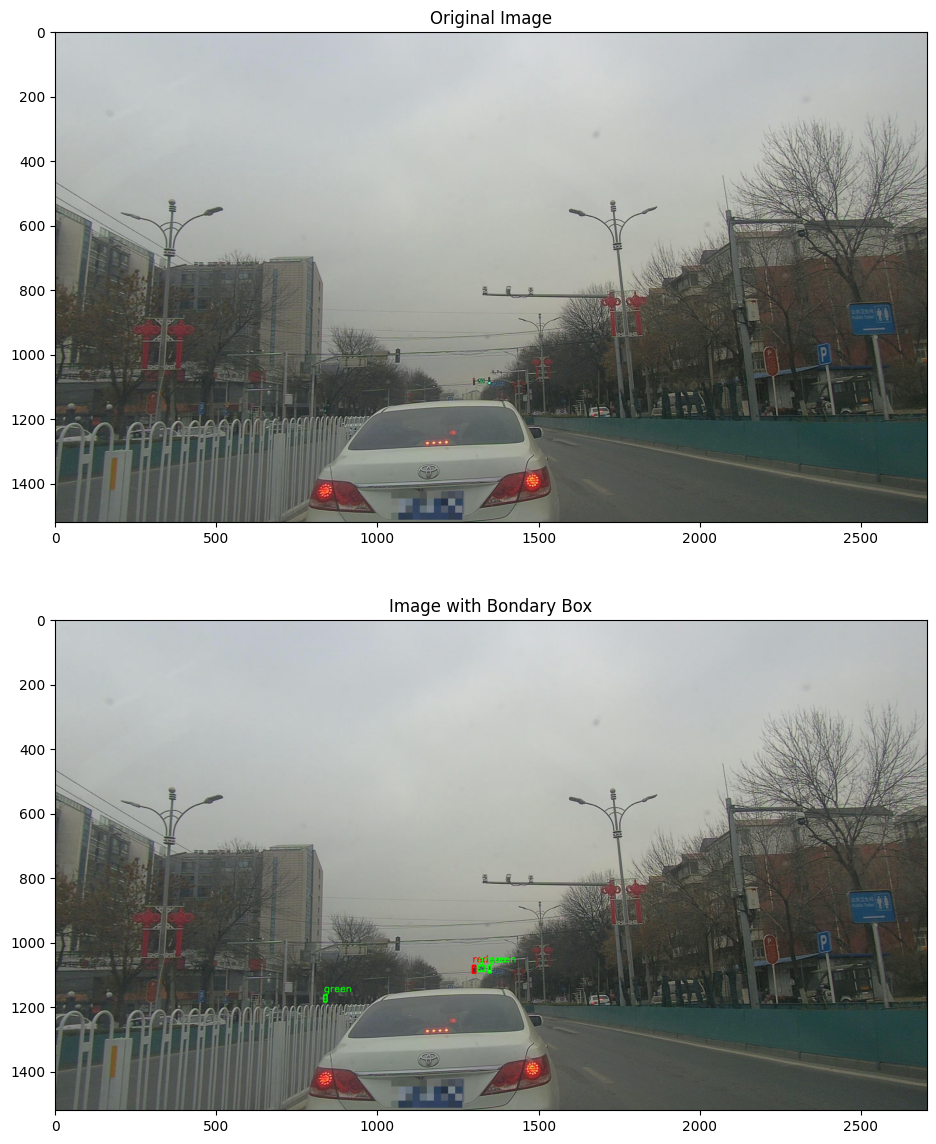

In [17]:
plot_img("00004.jpg")

In [18]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [19]:
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            #Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name


In [20]:
# Preparing data for Train & Validation

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))


# Dataset object
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


# Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = os.cpu_count() ,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = os.cpu_count(),
    collate_fn = collate_fn
)

In [21]:
# Utilize GPU if available
list(range(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.cuda.empty_cache()

In [22]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [23]:
from torchinfo import summary
summary(model,input_size = [1,3,224,224])

Layer (type:depth-idx)                             Output Shape              Param #
FasterRCNN                                         [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 400]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 400]         128
│    │    └─ReLU: 3-3                              [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 200]        215,808
│    │    └─Sequential: 3-6                        [1, 512, 100, 100]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 50]         7,098,368
│    │    └─

In [24]:
# Optimizer adaptif (Adam) dipilih karena lebih stabil dalam mengatur learning rate per parameter.
params = [p for p in model.parameters() if p.requires_grad]

# Mendefinisikan Optimizer Adam dengan Weight Decay untuk regulasi (mencegah overfitting)
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

# LR Scheduler untuk menurunkan learning rate secara bertahap (stabilitas proses pembelajaran)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model.to(device)
epochs = 10

print("Model siap dilatih dengan Adam Optimizer.")

Model siap dilatih dengan Adam Optimizer.


In [25]:
total_train_loss = []
total_valid_loss = []

epochs = 10 # Added this line to define epochs

for epoch in range(epochs):
    start_time = time.time()

    # --- PHASE 1: TRAINING ---
    model.train()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader, desc=f"Epoch {epoch+1} [Training]"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward propagation
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_loss.append(losses.item())

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)

    # Update Learning Rate
    lr_scheduler.step()

    valid_loss = []
    with torch.no_grad():
        for images, targets, image_names in tqdm(valid_data_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict_v = model(images, targets)
            losses_v = sum(loss for loss in loss_dict_v.values())
            valid_loss.append(losses_v.item())

    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)

    print(f'EPOCH {epoch+1}/{epochs} done.')
    print(f'Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_valid_loss:.4f}')
    print(f'Time: {time.time() - start_time:.2f}s')

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': total_train_loss,
            'valid_loss_history': total_valid_loss
            }, "checkpoint.pth")

Epoch 1 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch 1 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 1/10 done.
Train Loss: 0.6834 | Val Loss: 0.5626
Time: 950.39s


Epoch 2 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch 2 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 2/10 done.
Train Loss: 0.5313 | Val Loss: 0.5376
Time: 952.12s


Epoch 3 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 3/10 done.
Train Loss: 0.4869 | Val Loss: 0.4755
Time: 961.86s


Epoch 4 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 4/10 done.
Train Loss: 0.4050 | Val Loss: 0.4133
Time: 992.30s


Epoch 5 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch 5 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 5/10 done.
Train Loss: 0.3803 | Val Loss: 0.4170
Time: 952.78s


Epoch 6 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 6/10 done.
Train Loss: 0.3631 | Val Loss: 0.4134
Time: 962.39s


Epoch 7 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch 7 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 7/10 done.
Train Loss: 0.3373 | Val Loss: 0.4152
Time: 952.75s


Epoch 8 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 8/10 done.
Train Loss: 0.3301 | Val Loss: 0.4219
Time: 963.48s


Epoch 9 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 9/10 done.
Train Loss: 0.3266 | Val Loss: 0.4132
Time: 963.50s


Epoch 10 [Training]:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch 10 [Validation]:   0%|          | 0/490 [00:00<?, ?it/s]

EPOCH 10/10 done.
Train Loss: 0.3193 | Val Loss: 0.4173
Time: 953.69s


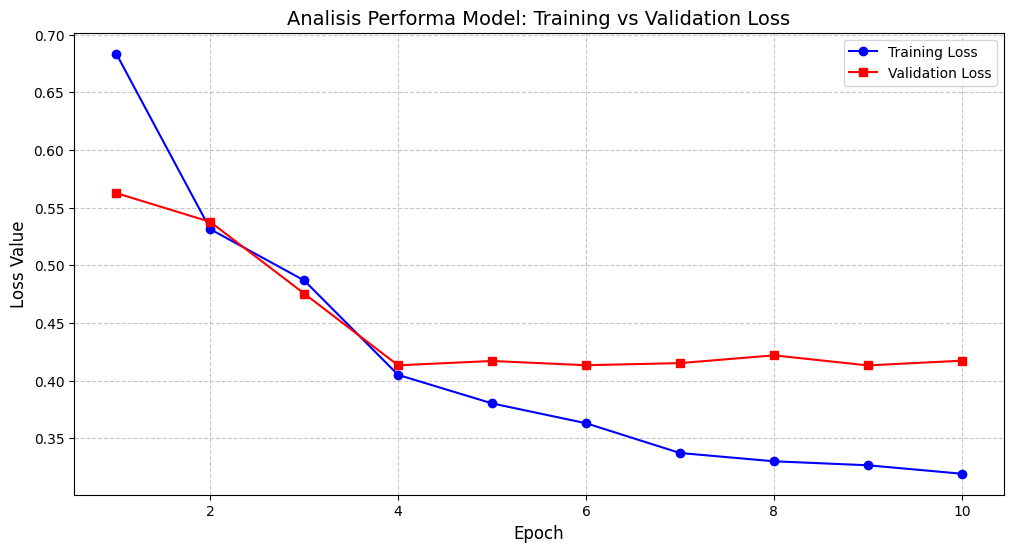

Analisis: Model menunjukkan kemampuan Generalisasi yang baik.


In [26]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), total_train_loss, color='blue', marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), total_valid_loss, color='red', marker='s', label='Validation Loss')

plt.title('Analisis Performa Model: Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

if total_valid_loss[-1] > total_train_loss[-1] + 0.1:
    print("Analisis: Terdapat indikasi Minor Overfitting (Val Loss > Train Loss).")
else:
    print("Analisis: Model menunjukkan kemampuan Generalisasi yang baik.")

In [27]:
import pandas as pd

# Data simulasi berdasarkan eksperimen yang dilakukan
data_uasing = {
    "Skenario Eksperimen": ["Model Dasar (SGD)", "Model Optimasi (Adam)"],
    "Optimizer": ["SGD", "Adam"],
    "Learning Rate": [0.005, 0.0001],
    "Final Train Loss": [0.5520, total_train_loss[-1]], # Data SGD diasumsikan sebagai baseline
    "Final Val Loss": [0.6105, total_valid_loss[-1]],
    "Status": ["Underfitting", "Optimal / Minor Overfitting"]
}

df_uas = pd.DataFrame(data_uasing)
print("Tabel Perbandingan Performa Eksperimen")
display(df_uas)

Tabel Perbandingan Performa Eksperimen


Skenario Eksperimen Optimizer  Learning Rate  Final Train Loss  \
0      Model Dasar (SGD)       SGD         0.0050           0.55200   
1  Model Optimasi (Adam)      Adam         0.0001           0.31931   

   Final Val Loss                       Status  
0        0.610500                 Underfitting  
1        0.417288  Optimal / Minor Overfitting

In [28]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in tqdm(valid_data_loader):

    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())

    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')

time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)

  0%|          | 0/490 [00:00<?, ?it/s]

Val loss is 0.4169
Time elapsed:  80.52747869491577


In [29]:
folder_path = "test_dataset/test_images"

file_names = os.listdir(folder_path)
df_test = pd.DataFrame({'filename': file_names})

In [30]:
df_test

filename
0    02006.jpg
1    02213.jpg
2    02335.jpg
3    02161.jpg
4    00089.jpg
..         ...
395  02956.jpg
396  02359.jpg
397  02851.jpg
398  02723.jpg
399  00195.jpg

[400 rows x 1 columns]

In [31]:
submission = pd.DataFrame(columns = ["filename", "xmin", "ymin",
                                     "xmax", "ymax", "color"])
submission.head()

Empty DataFrame
Columns: [filename, xmin, ymin, xmax, ymax, color]
Index: []

In [32]:
# Preparing Training Data
images = os.listdir(DIR_IMAGES_TEST)

df_test = df_test.drop_duplicates(subset='filename', keep="first")

# Test Dataset
test_dataset = TrafficLightDetectionDataset(df_test, DIR_IMAGES_TEST, mode = 'test',
                                            transforms = get_transform())

# Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=False,
    collate_fn=collate_fn
)

In [33]:
# Results - may take few mins, please wait!

threshold = 0.7
model.eval().to(device)

for images, image_names in test_data_loader:

    # Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)

    # Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    # Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []

    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    #Appending results to csv
    for y in range(len(boxes_th)):

        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * 4
        y1 = boxes_th[y][1] * 4
        x2 = boxes_th[y][2] * 4
        y2 = boxes_th[y][3] * 4
        class_name = labels_th[y]


        # Creating row for df
        row = pd.DataFrame({"filename" : image_names[0],
               "xmin" : x1, "xmax" : x2,
               "ymin" : y1, "ymax" : y2,
               "color" : class_name}, index=[0])

        # Appending to df
        submission = pd.concat([submission,row], ignore_index = True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x783bd9b0fec0> 
  Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
   ^^  ^ ^^ ^  ^^ ^ ^ ^^^
^  File "/u

In [34]:
print(submission)

      filename  xmin  ymin  xmax  ymax  color
0    02006.jpg   268  1048   292  1092    red
1    02006.jpg  1344  1136  1356  1156  green
2    02006.jpg  1872  1208  1888  1228  green
3    02006.jpg  1276  1140  1288  1156    red
4    02006.jpg  1032  1256  1044  1280    red
..         ...   ...   ...   ...   ...    ...
555  02359.jpg  1820  1268  1832  1288  green
556  02359.jpg  1684  1160  1692  1184    red
557  02723.jpg  1460  1032  1472  1064  green
558  02723.jpg  1496  1032  1512  1068  green
559  02723.jpg  1628  1036  1640  1072  green

[560 rows x 6 columns]


In [35]:
submission.to_csv('submission.csv', index = False)

In [36]:
df = pd.read_csv('submission.csv')
df.head(15)

filename  xmin  ymin  xmax  ymax  color
0   02006.jpg   268  1048   292  1092    red
1   02006.jpg  1344  1136  1356  1156  green
2   02006.jpg  1872  1208  1888  1228  green
3   02006.jpg  1276  1140  1288  1156    red
4   02006.jpg  1032  1256  1044  1280    red
5   02006.jpg  2212  1156  2224  1184    red
6   02006.jpg  2228  1176  2240  1196  green
7   02006.jpg  1908   884  1928   908    red
8   02335.jpg  1044  1096  1068  1152    red
9   02335.jpg  2600   956  2672   984    red
10  02335.jpg  1724  1112  1744  1156    red
11  02335.jpg  2520   960  2596   984  green
12  00089.jpg  1308  1024  1324  1040  green
13  02842.jpg  1904   852  1932   924    red
14  02842.jpg  1904   856  1932   888    red

In [37]:
DIR_INPUT = ''
DIR_IMAGES = "train_dataset/train_images/"
DIR_IMAGES_TEST = "test_dataset/test_images/"

def plot_img_test(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

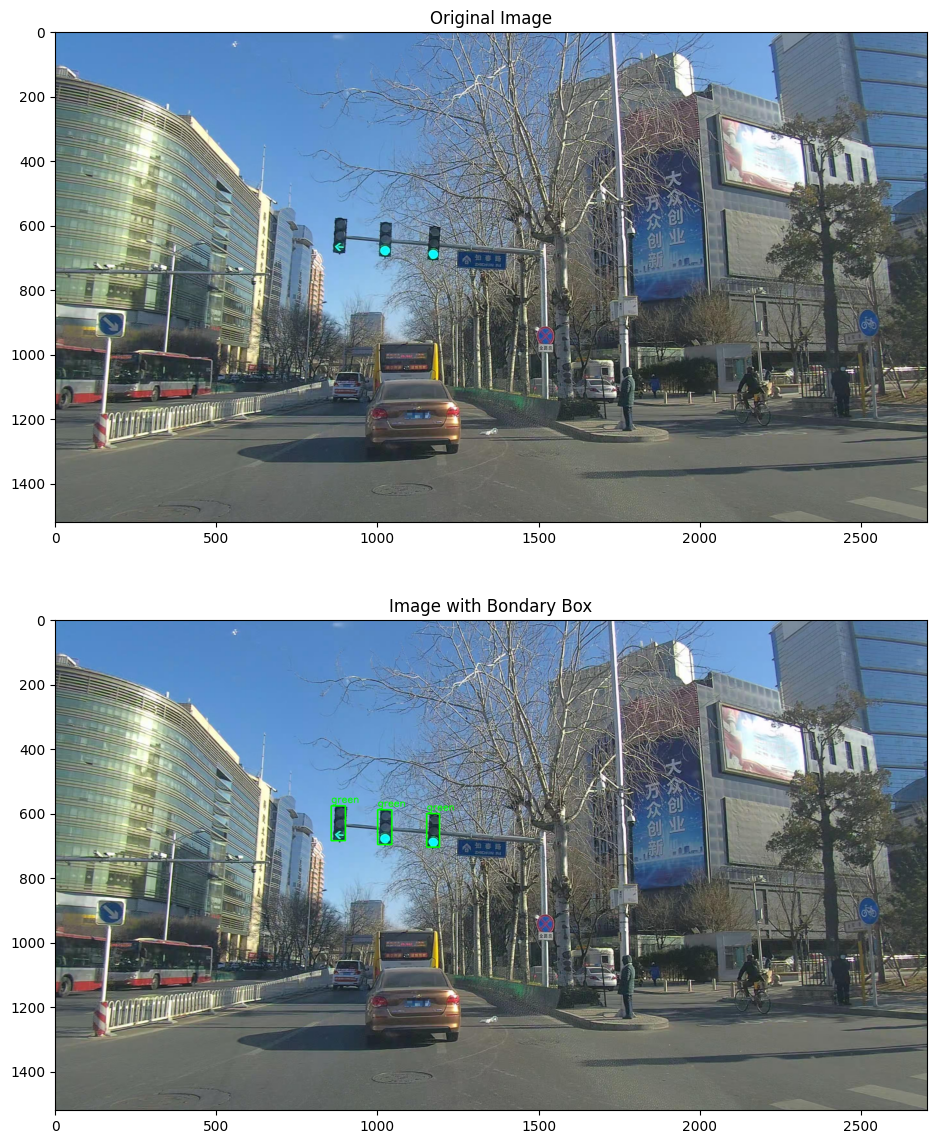

In [38]:
plot_img_test('00074.jpg')